# Imports

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar

import os
pd.set_option('display.max_columns', None)

# Setup

In [7]:
datapath = '/home/r3406/SharedFiles/Data/PublicData/KNHANES'
jar = 'jar'
NUM_CORES = os.cpu_count()
client = Client(asynchronous=True, n_workers=NUM_CORES)#, dashboard_address=':9988')


/opt/anaconda3/envs/lenv/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41341 instead
  warnings.warn(
distributed.diskutils - INFO - Found stale lock file and directory '/home/r3406/MyFiles/KHC/dask-worker-space/worker-jo6fpo6y', purging


In [8]:
# global

basic_mask = [ 
    #'year', 
    'age', 'sex',
]

nutri_useable_feats = [
    'n_wat_c',
    'nf_carot',
    'n_fm_wt',
    'nf_va',
    'nf_k',
    'n_kindg1',
    'n_kindg2',
    'nf_retin',
    'nf_na',
    'nf_phos',
    'nf_ca',
    'nf_intk',
    'nf_cho',
    'nf_en',
    'nf_water',
    'nf_fe',
    'nf_prot',
    'nf_fat',
    'nf_b1',
    'n_diet',
    'nf_vitc',
    'n_meal',
    'n_meal_t',
    'n_fcode',
    'n_mtype',
    'n_meal_p',
    'n_dcode',
    'nf_niac',
    'nf_b2',
    'n_dname',
    'n_ap',
    'n_fname',
    'n_day',
    'n_dusual',
    'n_cd_vol',
    'n_diet_why',
    'n_fname3',
    'n_fcode3',
    'nf_intk3',
    'n_td_vol',
    'n_fname2',
    'n_fcode2',
]

health_status_feats = [
    'DC1_dg',
    'DC11_dg',
    'DC12_dg',
    'DC2_dg',
    'DC3_dg',
    'DC4_dg',
    'DC5_dg',
    'DC6_dg',
    'DC7_dg',
    'DE1_dg',
    'DF2_dg',
    'DF2_dg',
    'DI1_dg',
    'DI3_dg',
    'DI4_dg',
    'DI5_dg',
    'DI6_dg',
    'DJ2_dg',
    'DJ4_dg',
    'DM1_dg',
    'DM2_dg',
    'DM3_dg',
    'DN1_dg',
    'DK4_dg',
]

white_list_prefix = [
    'D', 'H', 
]

In [11]:
# get paths to all dfs
df_paths = {'df_' + pickle.split('_')[1] + '_path':os.path.join(jar, pickle) for pickle in os.listdir(jar) if pickle.split('_')[2]=='all'}
df_paths

{'df_08_path': 'jar/knhanes_08_all_feats.csv',
 'df_09_path': 'jar/knhanes_09_all_feats.csv',
 'df_10_path': 'jar/knhanes_10_all_feats.csv',
 'df_11_path': 'jar/knhanes_11_all_feats.csv',
 'df_12_path': 'jar/knhanes_12_all_feats.csv',
 'df_13_path': 'jar/knhanes_13_all_feats.csv',
 'df_14_path': 'jar/knhanes_14_all_feats.csv',
 'df_05_path': 'jar/knhanes_05_all_feats.csv',
 'df_07_path': 'jar/knhanes_07_all_feats.csv',
 'df_15_path': 'jar/knhanes_15_all_feats.csv',
 'df_16_path': 'jar/knhanes_16_all_feats.csv',
 'df_17_path': 'jar/knhanes_17_all_feats.csv',
 'df_18_path': 'jar/knhanes_18_all_feats.csv',
 'df_19_path': 'jar/knhanes_19_all_feats.csv',
 'df_98_path': 'jar/knhanes_98_all_feats.csv'}

# Test

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [12]:
df = dd.read_csv(df_paths['df_17_path'])

In [13]:
df.shape

(Delayed('int-64d946da-e980-4769-a427-3369a0ff87cb'), 957)

In [17]:
# only keep (seemingly) NHIS compatible columns
prefix_feats = white_list_prefix
fullname_feats = basic_mask + nutri_useable_feats + health_status_feats
# lowercase all feats
for ls in (prefix_feats, fullname_feats):
    ls = [it.lower() for it in ls]

keep = [col for col in df.columns if col.split('_')[0].startswith(tuple(prefix_feats))] + \
    [col for col in fullname_feats if col in df.columns]
df_keep = df[keep]
print(df.shape)


(Delayed('int-eb9c7d2e-5750-4570-9228-721c698e0fd9'), 322)


In [18]:
# exclusion criteria: unhealthy status (morbidity == 1)
df_healthy = df_keep[~df_keep[[col for col in health_status_feats if col in df_keep.columns]].isin([1]).any(axis=1)]
df_healthy.shape

(Delayed('int-67c45b61-79e5-434c-ac82-90cc3637dec4'), 422)

In [19]:
# num 'unhealthy' rows reduced
print(df_keep.shape[0] - df_healthy.shape[0])

Delayed('sub-8d1f0dacb3591c74a919a54be77000b5')


In [20]:
# double check if value 1 exists in any health_status_feats
df_healthy[[col for col in health_status_feats if col in df_healthy.columns]].isin([1]).any(axis=1).sum()

dd.Scalar<series-..., dtype=int64>

In [21]:
# get df_nutri from those df_healthy
df_nutri = df_healthy[[col for col in nutri_useable_feats if col in df_healthy.columns]]
df_nutri.shape

(dd.Scalar<size-ag..., dtype=int64>, 0)

In [22]:
# take out nutri_feats
df_core = df_healthy.drop(df_nutri.columns, axis=1)
print(df_core.shape)
df_core.columns

(Delayed('int-669ae65d-b3ba-4a2d-97ea-86f12dcb95ab'), 422)


Index(['D_1_1', 'D_2_1', 'D_2_wk', 'DI1_dg', 'DI1_dg', 'DI1_ag', 'DI1_pr',
       'DI1_pt', 'DI1_2', 'DI2_dg',
       ...
       'DM1_dg', 'DM1_dg', 'DM2_dg', 'DM2_dg', 'DM3_dg', 'DM3_dg', 'DN1_dg',
       'DN1_dg', 'DK4_dg', 'DK4_dg'],
      dtype='object', length=422)

In [23]:
# double check size
df_healthy.shape[1] == df_nutri.shape[1] + df_core.shape[1]

True

In [25]:
# check with new method
df_core, df_nutri = get_df_core_df_nutri(df)
print(df_core.shape)
df_healthy.shape[1] == df_nutri.shape[1] + df_core.shape[1]

NameError: name 'get_df_core_df_nutri' is not defined

In [ ]:
df_core.info()
df_core.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481355 entries, 0 to 34144
Columns: 417 entries, D_1_1 to DK4_dg
dtypes: float64(406), object(11)
memory usage: 1.5+ GB


,D_1_1,D_2_wk,D_3_wk,DI1_ld,DG1_ld,DF1_ld,DC1_lt,DC1_yr,DC1_dg,DC1_pt,DC2_lt,DC2_yr,DC2_dg,DC2_pt,DC3_lt,DC3_yr,DC3_dg,DC3_pt,DC4_lt,DC4_yr,DC4_dg,DC4_pt,DC5_lt,DC5_yr,DC5_dg,DC5_pt,DC6_lt,DC6_yr,DC6_dg,DC6_pt,DC11_lt,DC7_yr,DC11_dg,DC11_pt,DC8_lt,DC8_yr,DC8_dg,DC8_pt,DC9_11,DC9_12,DC9_21,DC9_22,DM1_lt,DM1_yr,DM1_dg,DM1_pt,DM2_lt,DM2_yr,DM2_dg,DM2_pt,DM3_lt,DM3_yr,DM3_dg,DM3_pt,DM1_1,DM1_2,DM1_3,DM1_4,DM1_51,DM1_52,DM1_53,DM1_54,DM1_5,DM4_lt,DM4_yr,DM4_dg,DM4_pt,DM5_lt,DM5_yr,DM5_dg,DM5_pt,DE1_lt,DE1_yr,DE1_dg,DE1_pt,DE1_1,DE1_2,DE1_31,DE1_32,DE1_41,DE1_42,DE1_51,DE1_52,DE1_53,DE1_54,DE1_5,DE2_lt,DE2_yr,DE2_dg,DE2_pt,DK1_lt,DK1_yr,DK1_dg,DK1_pt,DK1_1,DK2_lt,DK2_yr,DK2_dg,DK2_pt,DK3_lt,DK3_yr,DK3_dg,DK3_pt,DK4_lt,DK4_yr,DK4_dg,DK4_pt,DI1_lt,DI1_yr,DI1_dg,DI1_pt,DI1_1,DI1_2,DI1_9,DI1_4,DI2_lt,DI2_yr,DI2_dg,DI2_pt,DI2_1,DI2_2,DI2_3,DI3_lt,DI3_yr,DI3_dg,DI3_pt,DI3_1,DI3_2,DI3_21,DI3_22,DI3_23,DI3_24,DI3_25,DI3_26,DI3_3,DI4_lt,DI4_yr,DI4_dg,DI4_pt,DI5_lt,DI5_yr,DI5_dg,DI5_pt,DI6_lt,DI6_yr,DI6_dg,DI6_pt,DI7_1,DI7_2,DI7_3,DI7_4,DI8_lt,DI8_yr,DI8_dg,DI8_pt,DJ1_lt,DJ1_yr,DJ1_dg,DJ1_pt,DJ2_lt,DJ2_yr,DJ2_dg,DJ2_pt,DJ3_lt,DJ3_yr,DJ3_dg,DJ3_pt,DJ2_1,DJ2_2,DJ2_3,DJ2_4,DJ4_lt,DJ4_yr,DJ4_dg,DJ4_pt,DJ4_1,DJ4_2,DJ4_3,DJ4_4,DJ4_5,DJ4_61,DJ4_62,DJ4_63,DJ4_64,DJ4_65,DJ5_lt,DJ5_yr,DJ5_dg,DJ5_pt,DJ5_1,DJ5_2,DJ5_21,DJ5_3,DJ5_4,DJ5_5,DJ6_lt,DJ6_yr,DJ6_dg,DJ6_pt,DJ7_lt,DJ7_yr,DJ7_dg,DJ7_pt,DJ8_lt,DJ8_yr,DJ8_dg,DJ8_pt,DJ8_1,DH1_lt,DH1_yr,DH1_dg,DH1_pt,DH2_lt,DH2_yr,DH2_dg,DH2_pt,DH3_lt,DH3_yr,DH3_dg,DH3_pt,DH4_lt,DH4_yr,DH4_dg,DH4_pt,DK5_lt,DK5_yr,DK5_dg,DK5_pt,DK5_1,DK6_lt,DK6_yr,DK6_dg,DK6_pt,DK7_lt,DK7_yr,DK7_dg,DK7_pt,DL1_lt,DL1_yr,DL1_dg,DL1_pt,DL1_1,DN1_lt,DN1_yr,DN1_dg,DN1_pt,DN2_lt,DN2_yr,DN2_dg,DN2_pt,DJ6_1,D_4_yd,DH5_yd,DN6_yd,DK7_yd,DB8_yd,DJ9_yd,D_10_yd,DF9_1,DF9_21,DF9_22,DF9_23,DF9_24,DF10_1,DF11_1,DF11_2,HE_WT,HE_HT,HE_WC,HE_FST,HE_tFST,HE_fFST,HE_DX,HE_DRUG,HE_MENS,HE_dPRG,HE_rPLS,HE_PLS,HE_mPLS,HE_mARM,HE_Cuff,HE_SBP1,HE_DBP1,HE_SBP2,HE_DBP2,HE_SBP3,HE_DBP3,HE_SBP,HE_DBP,HE_reBP,HE_BPrDT,HE_BPDT,HE_HPdrg,HE_rmARM,HE_rCuff,HE_rSBP1,HE_rDBP1,HE_rSBP2,HE_rDBP2,HE_rSBP3,HE_rDBP3,HE_rSBP,HE_rDBP,HE_ALT,HE_AST,HE_BUN,HE_CREA,HE_GLU,HE_GLU2,HE_CHOL,HE_HDL,HE_LDL,HE_TG,HE_HBsAg,HE_HbA1c,HE_WBC,HE_RBC,HE_HB,HE_HCT,HE_UpH,HE_Unitr,HE_USG,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ubld,HE_Uro,HE_hg,HE_pb,HE_cd,HS_FHP,HS_FHL,HS_FHRT,HS_FSTR,HS_FDM,HS_FCA,HS_FCA1,HS_FCA2,HS_FCA3,HS_DR1fq,HS_DR1qn,HS_DR2fq,HS_DR2qn,HS_DR3fq,HS_DR3qn,HS_DR4fq,HS_DR4qn,HS_DR5fq,HS_DR5qn,HS_DR6tp,HS_DR6fq,HS_DR6qn,HS_Dage,HS_PRGfq,HS_NABOR,HS_AABOR,HS_BF,HS_nBF,HS_dBF,HS_CONT,HS_dCONT,HS_ESTR,HS_tESTR,HS_sESTR,HS_qESTR,HS_dESTR,HM_res_y,HM_res_m,HM_rd_d,HM_j1,HM_j1_y,HM_j1_m,HM_j2,HM_j2_y,HM_j2_m,HM_j3,HM_j3_y,HM_j3_m,HM_j4,HM_j4_y,HM_j4_m,HM_j5,HM_j5_y,HM_j5_m,HM_j6,HM_j6_y,HM_j6_m,HM_j7,HM_j7_y,HM_j7_m,HM_j8,HM_j8_y,HM_j8_m,HM_reg_t,age,sex,DC1_dg,DC11_dg,DC2_dg,DC3_dg,DC4_dg,DC5_dg,DC6_dg,DE1_dg,DI1_dg,DI3_dg,DI4_dg,DI5_dg,DI6_dg,DJ2_dg,DJ4_dg,DM1_dg,DM2_dg,DM3_dg,DN1_dg,DK4_dg
403800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
# only keep columns wity type num
print(df_core.shape)
df_core = df_core.select_dtypes(include=['number'])
print(df_core.shape)
df_core.sample(5)

(481355, 417)
(481355, 406)


,D_1_1,D_2_wk,D_3_wk,DI1_ld,DG1_ld,DF1_ld,DC1_lt,DC1_yr,DC1_dg,DC1_pt,DC2_lt,DC2_yr,DC2_dg,DC2_pt,DC3_lt,DC3_yr,DC3_dg,DC3_pt,DC4_lt,DC4_yr,DC4_dg,DC4_pt,DC5_lt,DC5_yr,DC5_dg,DC5_pt,DC6_lt,DC6_yr,DC6_dg,DC6_pt,DC11_lt,DC7_yr,DC11_dg,DC11_pt,DC8_lt,DC8_yr,DC8_dg,DC8_pt,DC9_12,DC9_22,DM1_lt,DM1_yr,DM1_dg,DM1_pt,DM2_lt,DM2_yr,DM2_dg,DM2_pt,DM3_lt,DM3_yr,DM3_dg,DM3_pt,DM1_1,DM1_2,DM1_3,DM1_4,DM1_51,DM1_52,DM1_53,DM1_54,DM1_5,DM4_lt,DM4_yr,DM4_dg,DM4_pt,DM5_lt,DM5_yr,DM5_dg,DM5_pt,DE1_lt,DE1_yr,DE1_dg,DE1_pt,DE1_1,DE1_2,DE1_31,DE1_32,DE1_41,DE1_42,DE1_51,DE1_52,DE1_53,DE1_54,DE1_5,DE2_lt,DE2_yr,DE2_dg,DE2_pt,DK1_lt,DK1_yr,DK1_dg,DK1_pt,DK1_1,DK2_lt,DK2_yr,DK2_dg,DK2_pt,DK3_lt,DK3_yr,DK3_dg,DK3_pt,DK4_lt,DK4_yr,DK4_dg,DK4_pt,DI1_lt,DI1_yr,DI1_dg,DI1_pt,DI1_1,DI1_2,DI1_9,DI1_4,DI2_lt,DI2_yr,DI2_dg,DI2_pt,DI2_1,DI2_2,DI2_3,DI3_lt,DI3_yr,DI3_dg,DI3_pt,DI3_1,DI3_2,DI3_21,DI3_22,DI3_23,DI3_24,DI3_25,DI3_26,DI3_3,DI4_lt,DI4_yr,DI4_dg,DI4_pt,DI5_lt,DI5_yr,DI5_dg,DI5_pt,DI6_lt,DI6_yr,DI6_dg,DI6_pt,DI7_1,DI7_2,DI7_3,DI7_4,DI8_lt,DI8_yr,DI8_dg,DI8_pt,DJ1_lt,DJ1_yr,DJ1_dg,DJ1_pt,DJ2_lt,DJ2_yr,DJ2_dg,DJ2_pt,DJ3_lt,DJ3_yr,DJ3_dg,DJ3_pt,DJ2_1,DJ2_2,DJ2_3,DJ2_4,DJ4_lt,DJ4_yr,DJ4_dg,DJ4_pt,DJ4_1,DJ4_2,DJ4_3,DJ4_4,DJ4_5,DJ4_61,DJ4_62,DJ4_63,DJ4_64,DJ4_65,DJ5_lt,DJ5_yr,DJ5_dg,DJ5_pt,DJ5_1,DJ5_2,DJ5_21,DJ5_3,DJ5_4,DJ5_5,DJ6_lt,DJ6_yr,DJ6_dg,DJ6_pt,DJ7_lt,DJ7_yr,DJ7_dg,DJ7_pt,DJ8_lt,DJ8_yr,DJ8_dg,DJ8_pt,DJ8_1,DH1_lt,DH1_yr,DH1_dg,DH1_pt,DH2_lt,DH2_yr,DH2_dg,DH2_pt,DH3_lt,DH3_yr,DH3_dg,DH3_pt,DH4_lt,DH4_yr,DH4_dg,DH4_pt,DK5_lt,DK5_yr,DK5_dg,DK5_pt,DK5_1,DK6_lt,DK6_yr,DK6_dg,DK6_pt,DK7_lt,DK7_yr,DK7_dg,DK7_pt,DL1_lt,DL1_yr,DL1_dg,DL1_pt,DL1_1,DN1_lt,DN1_yr,DN1_dg,DN1_pt,DN2_lt,DN2_yr,DN2_dg,DN2_pt,DJ6_1,D_4_yd,DH5_yd,DN6_yd,DK7_yd,DB8_yd,DJ9_yd,D_10_yd,DF9_1,DF9_21,DF9_22,DF9_23,DF9_24,DF10_1,DF11_1,DF11_2,HE_WT,HE_HT,HE_WC,HE_FST,HE_DX,HE_DRUG,HE_MENS,HE_dPRG,HE_rPLS,HE_PLS,HE_mPLS,HE_mARM,HE_Cuff,HE_SBP1,HE_DBP1,HE_SBP2,HE_DBP2,HE_SBP3,HE_DBP3,HE_SBP,HE_DBP,HE_reBP,HE_HPdrg,HE_rmARM,HE_rCuff,HE_rSBP1,HE_rDBP1,HE_rSBP2,HE_rDBP2,HE_rSBP3,HE_rDBP3,HE_rSBP,HE_rDBP,HE_ALT,HE_AST,HE_BUN,HE_CREA,HE_GLU,HE_GLU2,HE_CHOL,HE_HDL,HE_LDL,HE_TG,HE_HBsAg,HE_HbA1c,HE_WBC,HE_RBC,HE_HB,HE_HCT,HE_UpH,HE_Unitr,HE_USG,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ubld,HE_Uro,HE_hg,HE_pb,HE_cd,HS_FHP,HS_FHL,HS_FHRT,HS_FSTR,HS_FDM,HS_FCA,HS_DR1fq,HS_DR1qn,HS_DR2fq,HS_DR2qn,HS_DR3fq,HS_DR3qn,HS_DR4fq,HS_DR4qn,HS_DR5fq,HS_DR5qn,HS_DR6fq,HS_DR6qn,HS_Dage,HS_PRGfq,HS_NABOR,HS_AABOR,HS_BF,HS_nBF,HS_dBF,HS_CONT,HS_dCONT,HS_ESTR,HS_sESTR,HS_qESTR,HS_dESTR,HM_res_y,HM_res_m,HM_rd_d,HM_j1,HM_j1_y,HM_j1_m,HM_j2,HM_j2_y,HM_j2_m,HM_j3,HM_j3_y,HM_j3_m,HM_j4,HM_j4_y,HM_j4_m,HM_j5,HM_j5_y,HM_j5_m,HM_j6,HM_j6_y,HM_j6_m,HM_j7,HM_j7_y,HM_j7_m,HM_j8,HM_j8_y,HM_j8_m,HM_reg_t,age,sex,DC1_dg,DC11_dg,DC2_dg,DC3_dg,DC4_dg,DC5_dg,DC6_dg,DE1_dg,DI1_dg,DI3_dg,DI4_dg,DI5_dg,DI6_dg,DJ2_dg,DJ4_dg,DM1_dg,DM2_dg,DM3_dg,DN1_dg,DK4_dg
159017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
# filter for age
min_age, max_age = 19, 70 # inclusive
df_core = df_core[(df_core.age >= min_age) & (df_core.age <= max_age)]
df_core.shape

(338492, 406)

<AxesSubplot:title={'center':'Distribution of nan rates'}, ylabel='Frequency'>

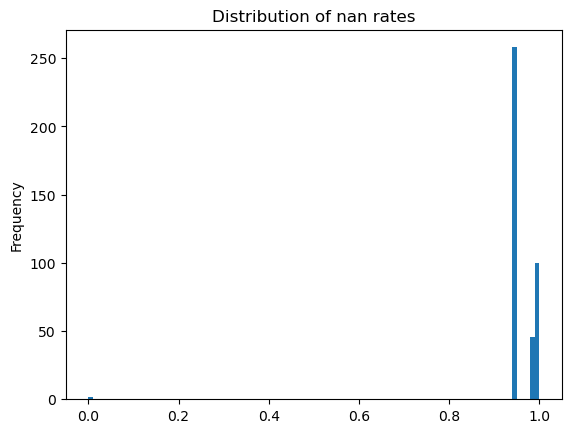

In [ ]:
# plot histogram of nan counts
nan_rates = df_core.isnull().sum()/df_core.shape[0]
nan_rates.plot(kind='hist', bins=100, title='Distribution of nan rates')

In [ ]:
# take out cols with nanrate gt n%
print(df_core.shape)
missing_rate_th = 0.3
num_not_missing = round(df_core.shape[0]*(1-missing_rate_th))
print(num_not_missing)
df_core_nna = df_core.dropna(axis=1, thresh=num_not_missing)
df_core_nna.shape

(338492, 406)
236944


(338492, 2)

In [ ]:
df_core_nna.head()

,D_1_1,D_2_wk,D_3_wk,DC1_lt,DC1_yr,DC1_dg,DC1_pt,DC2_lt,DC2_yr,DC2_dg,DC2_pt,DC3_lt,DC3_yr,DC3_dg,DC3_pt,DC4_lt,DC4_yr,DC4_dg,DC4_pt,DC5_lt,DC5_yr,DC5_dg,DC5_pt,DC6_lt,DC6_yr,DC6_dg,DC6_pt,DC11_lt,DC7_yr,DC11_dg,DC11_pt,DC8_lt,DC8_yr,DC8_dg,DC8_pt,DC9_12,DC9_22,DM1_lt,DM1_yr,DM1_dg,DM1_pt,DM2_lt,DM2_yr,DM2_dg,DM2_pt,DM3_lt,DM3_yr,DM3_dg,DM3_pt,DM1_1,DM1_2,DM1_3,DM1_4,DM1_51,DM1_52,DM1_53,DM1_54,DM1_5,DM4_lt,DM4_yr,DM4_dg,DM4_pt,DM5_lt,DM5_yr,DM5_dg,DM5_pt,DE1_lt,DE1_yr,DE1_dg,DE1_pt,DE1_2,DE1_31,DE1_32,DE1_41,DE1_42,DE1_51,DE1_52,DE1_53,DE1_54,DE1_5,DE2_lt,DE2_yr,DE2_dg,DE2_pt,DK1_lt,DK1_yr,DK1_dg,DK1_pt,DK2_lt,DK2_yr,DK2_dg,DK2_pt,DK3_lt,DK3_yr,DK3_dg,DK3_pt,DK4_lt,DK4_yr,DK4_dg,DK4_pt,DI1_lt,DI1_yr,DI1_dg,DI1_pt,DI1_1,DI1_2,DI1_9,DI1_4,DI2_lt,DI2_yr,DI2_dg,DI2_pt,DI2_1,DI2_2,DI2_3,DI3_lt,DI3_yr,DI3_dg,DI3_pt,DI3_1,DI3_2,DI3_21,DI3_22,DI3_23,DI3_24,DI3_25,DI3_26,DI3_3,DI4_lt,DI4_yr,DI4_dg,DI4_pt,DI5_lt,DI5_yr,DI5_dg,DI5_pt,DI6_lt,DI6_yr,DI6_dg,DI6_pt,DI7_1,DI7_2,DI7_3,DI7_4,DI8_lt,DI8_yr,DI8_dg,DI8_pt,DJ1_lt,DJ1_yr,DJ1_dg,DJ1_pt,DJ2_lt,DJ2_yr,DJ2_dg,DJ2_pt,DJ3_lt,DJ3_yr,DJ3_dg,DJ3_pt,DJ2_2,DJ2_3,DJ2_4,DJ4_lt,DJ4_yr,DJ4_dg,DJ4_pt,DJ4_2,DJ4_3,DJ4_4,DJ4_5,DJ4_61,DJ4_62,DJ4_63,DJ4_64,DJ4_65,DJ5_lt,DJ5_yr,DJ5_dg,DJ5_pt,DJ5_1,DJ5_2,DJ5_21,DJ5_3,DJ5_4,DJ5_5,DJ6_lt,DJ6_yr,DJ6_dg,DJ6_pt,DJ7_lt,DJ7_yr,DJ7_dg,DJ7_pt,DJ8_lt,DJ8_yr,DJ8_dg,DJ8_pt,DH1_lt,DH1_yr,DH1_dg,DH1_pt,DH2_lt,DH2_yr,DH2_dg,DH2_pt,DH3_lt,DH3_yr,DH3_dg,DH3_pt,DH4_lt,DH4_yr,DH4_dg,DH4_pt,DK5_lt,DK5_yr,DK5_dg,DK5_pt,DK6_lt,DK6_yr,DK6_dg,DK6_pt,DK7_lt,DK7_yr,DK7_dg,DK7_pt,DL1_lt,DL1_yr,DL1_dg,DL1_pt,DN1_lt,DN1_yr,DN1_dg,DN1_pt,DN2_lt,DN2_yr,DN2_dg,DN2_pt,HE_WT,HE_HT,HE_WC,HE_FST,HE_DX,HE_DRUG,HE_MENS,HE_rPLS,HE_PLS,HE_mARM,HE_Cuff,HE_SBP1,HE_DBP1,HE_SBP2,HE_DBP2,HE_SBP3,HE_DBP3,HE_SBP,HE_DBP,HE_reBP,HE_ALT,HE_AST,HE_BUN,HE_CREA,HE_GLU,HE_CHOL,HE_HDL,HE_LDL,HE_TG,HE_HBsAg,HE_WBC,HE_RBC,HE_HB,HE_HCT,HS_FHP,HS_FHL,HS_FHRT,HS_FSTR,HS_FDM,HS_FCA,HS_DR1fq,HS_DR2fq,HS_DR3fq,HS_DR4fq,HS_DR5fq,HS_DR6fq,age,sex,DC1_dg,DC11_dg,DC2_dg,DC3_dg,DC4_dg,DC5_dg,DC6_dg,DE1_dg,DI1_dg,DI3_dg,DI4_dg,DI5_dg,DI6_dg,DJ2_dg,DJ4_dg,DM1_dg,DM2_dg,DM3_dg,DN1_dg,DK4_dg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
# # test on og df
# df_nna = df.copy()
# print(df_nna.shape)
# df_nna.drop(['mod_d', 'id', 'year', 'region', 'psu', 'town_t', 'apt_t', 'age', 'sex',
#        'job_t', 'incm', 'ho_incm', 'incm5', 'ho_incm5', 'kstrata', 'edu','wt_24rc',], 
#        axis=1, inplace=True)
# missing_rate_th = 0.7
# num_not_missing = round(df.shape[0]*(1-missing_rate_th))
# print('num_not_missing', num_not_missing)
# df_nna.dropna(axis=1, thresh=num_not_missing, inplace=True)
# print(df_nna.shape)
# print(df_nna.columns)

In [ ]:
 # separate by sex after concatenation

# Concat all years

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [9]:
# settings
min_age, max_age = 19, 70 # inclusive
missing_rate_th = 0.3

# concatenator
df_allYears_ls = []
for df_path in df_paths:
    if int(df_path.split('_')[1]) >= 14: # test cond
        df = pd.read_pickle(df_paths[df_path])
        df.columns = df.columns.str.lower()
        # get healthy status dfs
        df_core, df_nutri = get_df_core_df_nutri(df)
        #mem clear
        del df, df_nutri#temp 
        # drop cols w nanrate gt missing_rate_th
        df_core.dropna(axis=1, inplace=True, 
            thresh=round(df_core.shape[0]*(1-missing_rate_th)))
        # drop non number cols
        df_core = df_core.select_dtypes(include=['number'])
        # filter age
        df_core = df_core[(df_core.age >= min_age) & (df_core.age <= max_age)]
        # skip ['age','sex'] only dfs
        if df_core.shape[1] <= 2:
            print('Not adding {} with shape of {}...'.format(df_path[:5], df_core.shape))
            continue
        df_allYears_ls.append(df_core)
        print('Added {} with final shape of {}!'.format(df_path[:5], df_core.shape))

df_allYears = pd.concat(df_allYears_ls)
df_allYears.shape


: 

: 

In [ ]:
# normalize

In [ ]:
# PCA where Y is AGE